## PART 0. packages, helper functions

In [1]:
import pandas as pd
import numpy as np

from plotnine import *
from mizani.formatters import percent_format
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

from patsy import dmatrices
from sklearn.model_selection import train_test_split
from skranger.ensemble import RangerForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence
from sklearn.utils import resample
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [3]:
def plot_pred_true_scatter(true_price,predicted_price,title="asd"):
    fig, ax = plt.subplots(figsize=(5,5))
    plt.scatter(true_price, predicted_price)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plt.xlabel("True price")
    plt.ylabel("Predicted price")
    plt.title(title)
    plt.show()
    
def corr_pred(array):
    return np.exp(array)*np.exp(residual_std)

## PART I
### Loading and preparing data 
----------------------------------------------

In [4]:
area = "bangkok"
data = pd.read_csv("../data/airbnb_" + area + "_workfile_all_am.csv")
data = data.loc[data.price.notna(), :]

In [5]:
data.isnull().sum().sum()

0

In [6]:
# Sample definition 
data = data.query('2 <= n_accommodates <= 6')

In [7]:
data.shape

(8162, 137)

Convert price form thai bahn to EUR for easier interpretation

In [8]:
data["price"] = data["price"] / 38.89

In [9]:
data.price.describe(percentiles=[0.5,0.9,0.95,0.98])

count    8162.000000
mean       45.074182
std       125.719504
min         6.916945
50%        28.220622
90%        73.458473
95%       101.736950
98%       191.620982
max      6547.261507
Name: price, dtype: float64

In [10]:
data.describe().T.head(30)

,count,mean,std,min,25%,50%,75%,max
price,8162.0,45.074182,125.719504,6.916945,18.770892,28.220622,43.713037,6547.261507
price_clean,8162.0,1752.934942,4889.231501,269.000000,730.000000,1097.500000,1700.000000,254623.000000
n_bathrooms,8162.0,1.223291,0.507486,0.000000,1.000000,1.000000,1.500000,23.000000
n_accommodates,8162.0,2.894511,1.142799,2.000000,2.000000,2.000000,4.000000,6.000000
n_review_scores_rating,8162.0,4.667452,0.618247,0.000000,4.690000,4.800000,4.890000,5.000000
n_number_of_reviews,8162.0,18.873683,40.229989,0.000000,0.000000,3.000000,19.000000,1116.000000
n_reviews_per_month,8162.0,0.607166,0.794160,0.010000,0.220000,0.380000,0.660000,24.310000
n_minimum_nights,8162.0,16.302867,43.728870,1.000000,1.000000,2.000000,20.000000,730.000000
n_beds,8162.0,1.448542,0.794301,0.000000,1.000000,1.000000,2.000000,7.000000
n_maximum_nights,8162.0,891.822838,1950.527949,1.000000,365.000000,1125.000000,1125.000000,100000.000000


<AxesSubplot:>

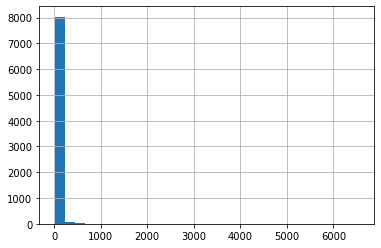

In [11]:
data.price.hist(bins=30)

<AxesSubplot:>

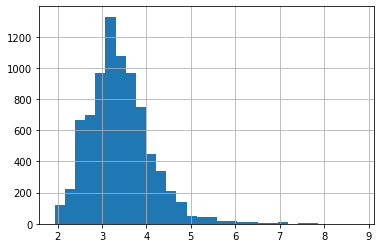

In [12]:
np.log(data.price).hist(bins=30)

In [13]:
data["lnprice"] = np.log(data.price)

In [14]:
data.f_property_type.value_counts()

Entire rental unit            4347
Entire condominium (condo)    3382
Entire serviced apartment      433
Name: f_property_type, dtype: int64

In [15]:
data.f_number_of_reviews.value_counts()

1    4650
0    2577
2     935
Name: f_number_of_reviews, dtype: int64

Create train and holdout samples 

In [16]:
data.f_neighbourhood_cleansed.value_counts()

Khlong Toei        1452
Vadhana            1133
Huai Khwang         825
Ratchathewi         660
Sathon              423
Other               400
Bang Rak            340
Phra Khanong        339
Bang Na             300
Din Daeng           257
Chatu Chak          254
Parthum Wan         235
Khlong San          214
Suanluang           189
Phaya Thai          182
Bang Sue            144
Bang Kapi           123
Bang Phlat          118
Yan na wa           118
Thon buri           104
Phasi Charoen        90
Bang Kho laen        77
Lat Krabang          74
Wang Thong Lang      62
Pra Wet              49
Name: f_neighbourhood_cleansed, dtype: int64

In [17]:
data.columns = [
    item.replace("\\", "").replace(":", "") for item in data.columns.tolist()
]

In [18]:
data.drop(["id","price_clean"],axis=1,inplace=True)

In [19]:
data_train, data_holdout = train_test_split(data, train_size=0.7, random_state=52)

print(data_train.shape, data_holdout.shape)

# Yay! same number of variables in train and holdout

(5713, 136) (2449, 136)


### Now remove error values from train set!

In [20]:
data_train = data_train.loc[lambda x: x["price"] < x["price"].describe(percentiles=[0.98])["98%"]]

In [21]:
all_variables = [item.replace("\\","").replace(":","") for item in data.columns.tolist()[1:-19]]

target_variable = "price"

# interactions for the LASSO

X1 = [
    "n_accommodates:f_property_type",
    "f_property_type:n_dist_to_grand_palace",
    "n_accommodates:d_longtermstaysallowed",
    "d_breakfast:f_property_type",
    "d_kitchen:f_property_type",
    "d_elevator:f_property_type",
    "d_essentials:f_property_type"
]
# with boroughs
X2 = [
    "f_property_type:f_neighbourhood_cleansed",
    "n_accommodates:f_neighbourhood_cleansed",
]

predictors_tree = all_variables
predictors_lasso = all_variables + X1 + X2

In [22]:
len(predictors_lasso)

125

## PART II
### Select hyperparameters for models with CV
-------------------------------------------------------

0. first, OLS reference model

In [22]:
y, X = dmatrices(target_variable + " ~ " + " + ".join(predictors_tree), data_train)
y_hold, X_test = dmatrices(
    target_variable + " ~ " + " + ".join(predictors_tree), data_holdout
)
y_hold_t, X_test_t = dmatrices(
    target_variable + " ~ " + " + ".join(predictors_tree),
    data_holdout.loc[lambda x: x["price"] < 190],
)

ols_model = LinearRegression().fit(X, y)

y_hat = ols_model.predict(X)

ols_rmse = mean_squared_error(y, y_hat, squared=False)
print(ols_rmse)

y_hat_test = ols_model.predict(X_test)
ols_rmse_test = mean_squared_error(y_hold, y_hat_test, squared=False)
print(ols_rmse_test)

y_hat_t = ols_model.predict(X_test_t)
ols_rmse_test_t = mean_squared_error(y_hold_t, y_hat_t, squared=False)
print(ols_rmse_test_t)

19.551291533202726
82.2574566579383
19.411049397500552


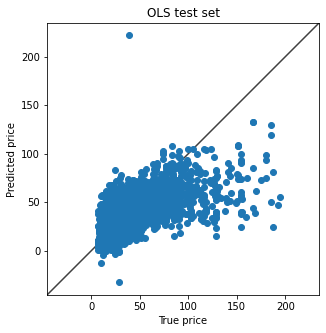

In [23]:
plot_pred_true_scatter(y, y_hat,title='OLS test set')

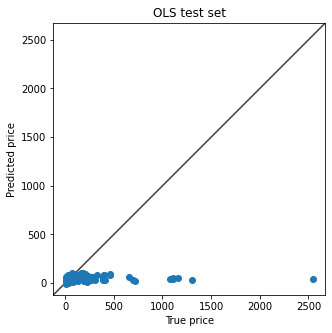

In [24]:
plot_pred_true_scatter(y_hold,y_hat_test,title='OLS test set')

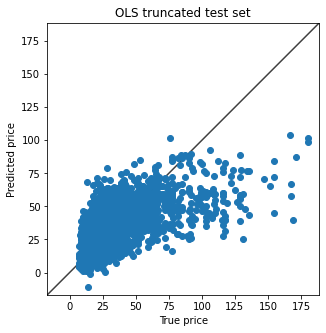

In [25]:
plot_pred_true_scatter(y_hold_t, y_hat_t,title='OLS truncated test set')

1.  LASSO

using extended model w interactions

In [26]:
lasso_model = ElasticNet(l1_ratio=1, fit_intercept=True)

lasso_pipeline = Pipeline([("scale", StandardScaler()), ("regressor", lasso_model)])

lasso_model_cv = GridSearchCV(
    lasso_model,
    {"alpha": [i / 100 for i in range(10, 50, 3)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)



y, X = dmatrices(target_variable + " ~ " + " + ".join(predictors_lasso), data_train)

lasso_model_cv.fit(X, y.ravel())

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5] END .......................alpha=0.1;, score=-20.522 total time=   0.1s
[CV 2/5] END .......................alpha=0.1;, score=-19.978 total time=   0.1s
[CV 3/5] END .......................alpha=0.1;, score=-21.451 total time=   0.1s
[CV 4/5] END .......................alpha=0.1;, score=-20.310 total time=   0.1s
[CV 5/5] END .......................alpha=0.1;, score=-20.335 total time=   0.1s
[CV 1/5] END ......................alpha=0.13;, score=-20.590 total time=   0.1s
[CV 2/5] END ......................alpha=0.13;, score=-20.134 total time=   0.1s
[CV 3/5] END ......................alpha=0.13;, score=-21.516 total time=   0.1s
[CV 4/5] END ......................alpha=0.13;, score=-20.405 total time=   0.1s
[CV 5/5] END ......................alpha=0.13;, score=-20.468 total time=   0.1s
[CV 1/5] END ......................alpha=0.16;, score=-20.648 total time=   0.1s
[CV 2/5] END ......................alpha=0.16;, 

GridSearchCV(cv=5, estimator=ElasticNet(l1_ratio=1),
             param_grid={'alpha': [0.1, 0.13, 0.16, 0.19, 0.22, 0.25, 0.28,
                                   0.31, 0.34, 0.37, 0.4, 0.43, 0.46, 0.49]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [27]:
lasso_rmse = pd.DataFrame(lasso_model_cv.cv_results_).loc[
    lambda x: x.param_alpha == lasso_model_cv.best_estimator_.alpha
].mean_test_score.values[0] * -1
lasso_rmse

20.51925838508274

In [28]:
rfr = RangerForestRegressor(importance="impurity",seed = 42)

tune_grid = {"mtry": [8, 10, 12], "min_node_size": [5, 10, 15]}

rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

y, X = dmatrices(target_variable + " ~ " + " + ".join(predictors_tree), data_train)

rf_model = rf_random.fit(X,y.ravel())

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .........min_node_size=5, mtry=8;, score=-18.928 total time=   1.0s
[CV 2/5] END .........min_node_size=5, mtry=8;, score=-18.110 total time=   1.0s
[CV 3/5] END .........min_node_size=5, mtry=8;, score=-17.601 total time=   1.0s
[CV 4/5] END .........min_node_size=5, mtry=8;, score=-18.442 total time=   0.9s
[CV 5/5] END .........min_node_size=5, mtry=8;, score=-18.488 total time=   1.0s
[CV 1/5] END ........min_node_size=5, mtry=10;, score=-18.682 total time=   1.1s
[CV 2/5] END ........min_node_size=5, mtry=10;, score=-18.076 total time=   1.1s
[CV 3/5] END ........min_node_size=5, mtry=10;, score=-17.574 total time=   1.1s
[CV 4/5] END ........min_node_size=5, mtry=10;, score=-18.329 total time=   1.1s
[CV 5/5] END ........min_node_size=5, mtry=10;, score=-18.263 total time=   1.1s
[CV 1/5] END ........min_node_size=5, mtry=12;, score=-18.689 total time=   1.2s
[CV 2/5] END ........min_node_size=5, mtry=12;, s

In [29]:
pd.DataFrame(rf_model.cv_results_)[
    ["param_mtry", "param_min_node_size", "mean_test_score"]
].assign(
    mean_test_score=lambda x: x["mean_test_score"] * -1,
    Variables=lambda x: x["param_mtry"],
    Min_nodes=lambda x: x["param_min_node_size"],
).pivot(
    index="Min_nodes", columns="Variables", values="mean_test_score"
).round(
    4
)

Variables,8,10,12
Min_nodes,,,
5,18.3137,18.1848,18.1117
10,18.5830,18.4588,18.3061
15,18.7264,18.6323,18.4399


## XGBoost

In [30]:
xgb_cv = XGBRegressor(seed = 42)

tune_grid = {"max_depth": [6, 8, 10],"eta":[0.1,0.2,0.3]}

xrb_cv = GridSearchCV(
    xgb_cv,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

y, X = dmatrices(target_variable + " ~ " + " + ".join(predictors_tree), data_train)

xgb_model = xrb_cv.fit(X, y.ravel())

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ............eta=0.1, max_depth=6;, score=-18.314 total time=   2.5s
[CV 2/5] END ............eta=0.1, max_depth=6;, score=-17.863 total time=   2.4s
[CV 3/5] END ............eta=0.1, max_depth=6;, score=-17.094 total time=   2.4s
[CV 4/5] END ............eta=0.1, max_depth=6;, score=-18.701 total time=   2.4s
[CV 5/5] END ............eta=0.1, max_depth=6;, score=-18.516 total time=   2.4s
[CV 1/5] END ............eta=0.1, max_depth=8;, score=-18.022 total time=   3.2s
[CV 2/5] END ............eta=0.1, max_depth=8;, score=-17.656 total time=   3.2s
[CV 3/5] END ............eta=0.1, max_depth=8;, score=-17.426 total time=   3.3s
[CV 4/5] END ............eta=0.1, max_depth=8;, score=-18.767 total time=   3.3s
[CV 5/5] END ............eta=0.1, max_depth=8;, score=-17.801 total time=   3.2s
[CV 1/5] END ...........eta=0.1, max_depth=10;, score=-18.783 total time=   4.2s
[CV 2/5] END ...........eta=0.1, max_depth=10;, s

In [31]:
pd.DataFrame(xgb_model.cv_results_)[
    ["param_max_depth","param_eta", "mean_test_score"]
].assign(
    mean_test_score=lambda x: x["mean_test_score"] * -1,
    Max_Depth=lambda x: x["param_max_depth"],
    Learning_rate=lambda x: x["param_eta"],
).pivot(
    index="Max_Depth", columns="Learning_rate", values="mean_test_score"
).round(
    4
)

Learning_rate,0.1,0.2,0.3
Max_Depth,,,
6,18.0977,18.0524,18.4825
8,17.9345,18.0168,18.4456
10,18.1524,18.3394,18.2351


### Get best models from every model type

In [32]:
pd.DataFrame(
    {
        "RMSE": [
            ols_rmse,
            lasso_rmse,
            rf_model.cv_results_["mean_test_score"].max() *-1,
            xgb_model.cv_results_["mean_test_score"].max()*-1,
        ]
    },
    ["Reference OLS", "Lasso CV", "Random Forest CV", "XGBoost CV"],
).round(2)

,RMSE
Reference OLS,19.55
Lasso CV,20.52
Random Forest CV,18.11
XGBoost CV,17.93


## Part III fit final model

Now, train the chosen XGB model, on the whole train test!

In [23]:
#final_model = Pipeline([("scale", StandardScaler()), ("regressor", xgb_model.best_estimator_)])
final_model = Pipeline([("scale", StandardScaler()), ("regressor", XGBRegressor(max_depth = 8, eta = 0.1))])

In [24]:
y, X = dmatrices(target_variable + " ~ " + " + ".join(predictors_tree), data_train)

xgb_final_fit = final_model.fit(X,y.ravel())


y_hat = xgb_final_fit.predict(X)

rf_rmse_train = mean_squared_error(y,y_hat,squared=False)
residual_std = np.std(y-y_hat)

print("Final model train rmse: "+str(rf_rmse_train))

y_hold, X_hold = dmatrices(target_variable + " ~ " + " + ".join(predictors_tree), data_holdout)

y_hat_test = xgb_final_fit.predict(X_hold)

rf_rmse_test = mean_squared_error(y_hold,y_hat_test,squared=False)
print("Final model test rmse: "+ str(rf_rmse_test))

Final model train rmse: 8.07370570463492
Final model test rmse: 81.60433837002562


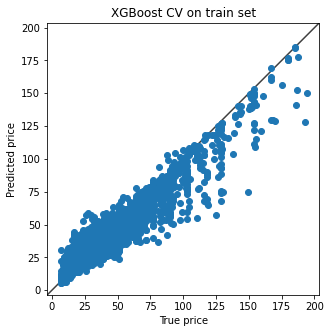

In [25]:
plot_pred_true_scatter(y,y_hat,title='XGBoost CV on train set')

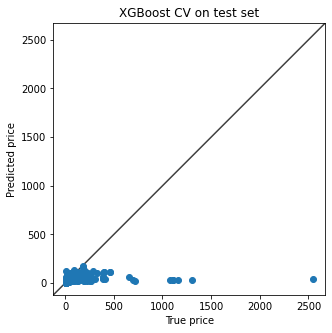

In [26]:
plot_pred_true_scatter(y_hold,y_hat_test,title='XGBoost CV on test set')

Final model truncated test rmse: 17.133610103688568


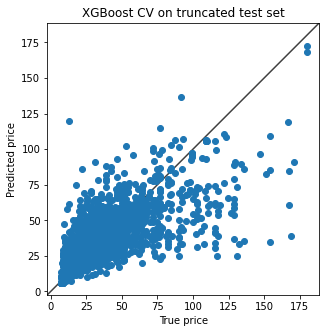

In [27]:
y_hold, X_hold = dmatrices(
    target_variable + " ~ " + " + ".join(predictors_tree),
    data_holdout.loc[lambda x: x["price"] < 190],
)

y_hat_test = xgb_final_fit.predict(X_hold)

rf_rmse_test = mean_squared_error(y_hold, y_hat_test, squared=False)
print("Final model truncated test rmse: " + str(rf_rmse_test))
plot_pred_true_scatter(
    y_hold, y_hat_test, title="XGBoost CV on truncated test set"
)

## PART III
### MODEL DIAGNOSTICS 
---

In [28]:
final_model_var_imp_df = (
    pd.DataFrame(final_model.steps[1][1].feature_importances_, X.design_info.column_names)
    .reset_index()
    .rename({"index": "varname", 0: "imp"}, axis=1)
    .assign(imp_percentage=lambda x: x["imp"] / x["imp"].sum())
    .sort_values(by=["imp"], ascending=False)
)

**1) full varimp plot, above a cutoff**

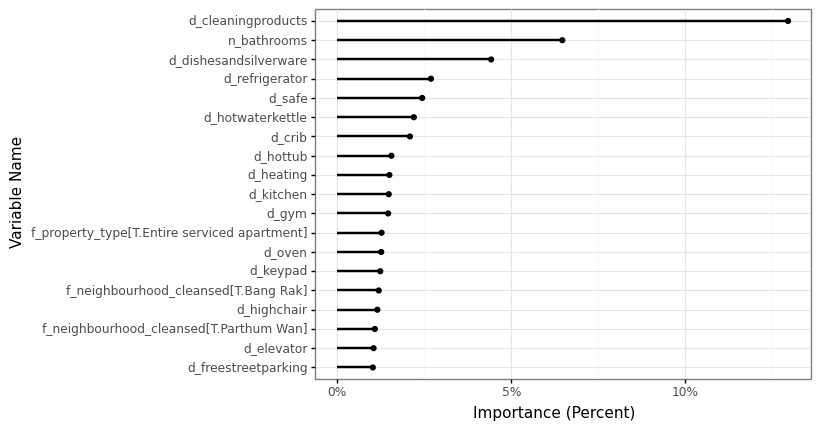

<ggplot: (303766396)>

In [29]:
ggplot(
    final_model_var_imp_df.loc[lambda x: x["imp_percentage"]>0.01],
    aes(x="reorder(varname, imp)", y="imp_percentage"),
) + geom_point(size=1.5) + geom_segment(
    aes(x="varname", xend="varname", y=0, yend="imp_percentage"), size=1
) + ylab(
    "Importance (Percent)"
) + xlab(
    "Variable Name"
) + coord_flip() + scale_y_continuous(
    labels=percent_format()
) + theme_bw()

**2) full varimp plot, top 10 only**

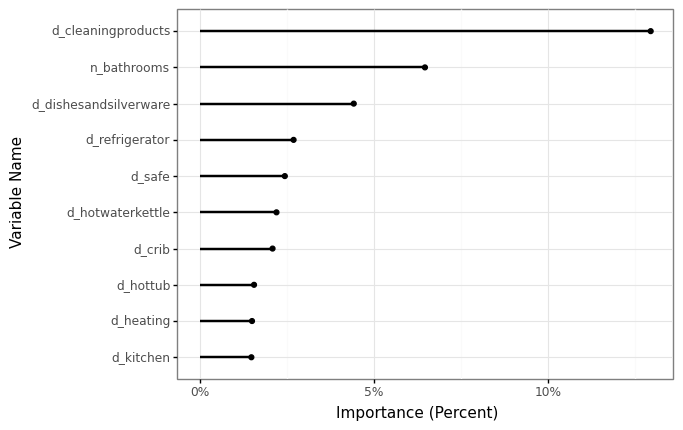

<ggplot: (303853939)>

In [30]:
ggplot(
    final_model_var_imp_df.iloc[:10, :],
    aes(x="reorder(varname, imp)", y="imp_percentage"),
) + geom_point(size=1.5) + geom_segment(
    aes(x="varname", xend="varname", y=0, yend="imp_percentage"), size=1
) + ylab(
    "Importance (Percent)"
) + xlab(
    "Variable Name"
) + coord_flip() + scale_y_continuous(
    labels=percent_format()
) + theme_bw()

**3) grouped variable importance - keep binaries created off factors together**

In [31]:
categorical_columns = [col for col in predictors_tree if col.startswith("f_")]
numerical_columns = [col for col in predictors_tree if col not in categorical_columns]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

final_pipeline = Pipeline(
    [("preprocess", preprocessing), ("regressor", xgb_final_fit)]
)

final_pipeline.fit(data_train[predictors_tree],data_train[target_variable])

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_neighbourhood_cleansed']),
                                                 ('num', 'passthrough',
                                                  ['n_bathrooms',
                                                   'n_accommodates',
                                                   'n_review_scores_rating',
                                                   'n_number_of_reviews',
                                                   'n_reviews_per_month',
                                                   'n_minimum_nights', 'n_beds',
                                                   'n_maximum_nights',
                                                   'n_days_since',
                    

In [74]:
# this takes a while to run
result = permutation_importance(
    final_pipeline,
    data_holdout[predictors_tree],
    data_holdout[target_variable],
    n_repeats=10,
    random_state=45,
)

In [75]:
categorical_columns

['f_property_type', 'f_neighbourhood_cleansed']

In [76]:
grouped_imp = (
    pd.DataFrame(
        result.importances_mean,
        data_train[predictors_tree].columns,
    )
    .reset_index()
    .rename({"index": "varname", 0: "imp"}, axis=1)
    .assign(imp_percentage=lambda x: x["imp"] / x["imp"].sum())
    .sort_values(by=["imp"], ascending=False)
    .head(10)
)

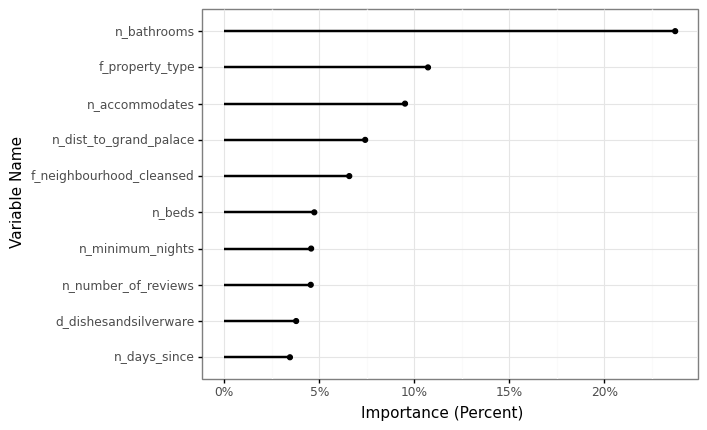

<ggplot: (300957061)>

In [77]:
ggplot(grouped_imp, aes(x="reorder(varname, imp)", y="imp_percentage"),) + geom_point( size=1.5
) + geom_segment(
    aes(x="varname", xend="varname", y=0, yend="imp_percentage"), size=1
) + ylab(
    "Importance (Percent)"
) + xlab(
    "Variable Name"
) + coord_flip() + scale_y_continuous(
    labels=percent_format()
) + theme_bw()

## Partial Dependence Plots 
-------------------------------------------------------


In [35]:
bath_pdp = partial_dependence(
    final_pipeline.fit(data_train[predictors_tree],data_train[target_variable]),
    data_holdout[predictors_tree].assign(
        n_bathrooms=lambda x: x["n_bathrooms"].astype(int)
    ),
    ["n_bathrooms"],
    kind="average",
)

bath_pdp = (
    pd.DataFrame(bath_pdp["average"], columns=bath_pdp["values"][0].tolist())
    .T.reset_index()
    .rename({0: "Predicted price", "index": "Bathrooms"}, axis=1)
)


n_bootstrap = 50

bathrooms = bath_pdp["Bathrooms"].tolist()
expected_value_bootstrap_replications = []
for _ in range(n_bootstrap):
    X_boot, y_boot = resample(
        data_holdout[predictors_tree].assign(
            n_bathrooms=lambda x: x["n_bathrooms"].astype(int)
        ),
        data_holdout[target_variable],
    )

    final_booted = final_pipeline.fit(X_boot, y_boot)

    expected_value_bootstrap_replications.append(
        partial_dependence(final_booted, X_boot, ["n_bathrooms"], kind="average")[
            "average"
        ][0]
    )

bath_pdp["prediction_se"] = (
    pd.DataFrame(expected_value_bootstrap_replications).dropna().std(axis=0).tolist()
)

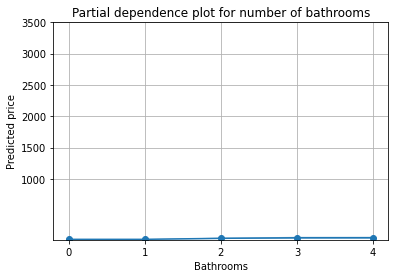

In [36]:
plt.plot(bathrooms, bath_pdp["Predicted price"],marker="o")
plt.fill_between(
    bathrooms,
    bath_pdp["Predicted price"] - 1.96 * bath_pdp["prediction_se"],
    bath_pdp["Predicted price"] + 1.96 * bath_pdp["prediction_se"],
    alpha=0.5,
    label="Bootstrap 95%CI",
)
plt.ylabel("Predicted price")
plt.xlabel("Bathrooms")
plt.title("Partial dependence plot for number of bathrooms")
plt.grid()
plt.xticks(bathrooms)
plt.show()

In [37]:
accom_pdp = partial_dependence(
    final_pipeline, data_holdout[predictors_tree], ["n_accommodates"], kind="average"
)

accom_pdp = (
    pd.DataFrame(accom_pdp["average"], columns=accom_pdp["values"][0].tolist())
    .T.reset_index()
    .rename({0: "Predicted price", "index": "Accomodates (person)"}, axis=1)
)


n_bootstrap = 50

accomodates = accom_pdp["Accomodates (person)"].tolist()
expected_value_bootstrap_replications = []
for _ in range(n_bootstrap):
    X_boot, y_boot = resample(
        data_holdout[predictors_tree], data_holdout[target_variable]
    )

    final_booted = final_pipeline.fit(X_boot, y_boot)

    expected_value_bootstrap_replications.append(
        partial_dependence(final_booted, X_boot, ["n_accommodates"], kind="average")[
            "average"
        ][0]
    )


accom_pdp["prediction_se"] = np.std(expected_value_bootstrap_replications, axis=0)[0]

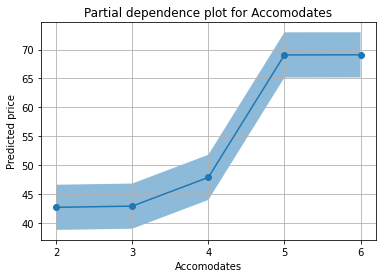

In [40]:
plt.plot(accomodates, accom_pdp["Predicted price"],marker="o")
plt.fill_between(
    accomodates,
    accom_pdp["Predicted price"] - 1.96 * accom_pdp["prediction_se"],
    accom_pdp["Predicted price"] + 1.96 * accom_pdp["prediction_se"],
    alpha=0.5,
    label="Bootstrap 95%CI",
)
plt.ylabel("Predicted price")
plt.xlabel("Accomodates")
plt.title("Partial dependence plot for Accomodates")
plt.grid()
plt.xticks(accomodates)
plt.show()

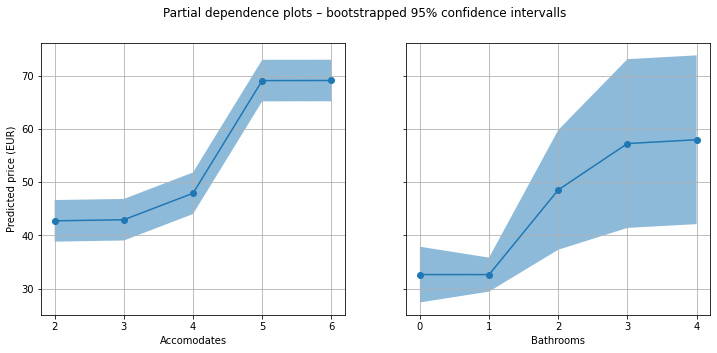

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2,sharey=True,figsize=(12,5))
fig.suptitle('Partial dependence plots – bootstrapped 95% confidence intervalls')



ax1.plot(accomodates, accom_pdp["Predicted price"], marker="o")
ax1.fill_between(
    accomodates,
    accom_pdp["Predicted price"] - 1.96 * accom_pdp["prediction_se"],
    accom_pdp["Predicted price"] + 1.96 * accom_pdp["prediction_se"],
    alpha=0.5,
    label="Bootstrap 95%CI",
)
ax1.set_ylabel("Predicted price (EUR)")
ax1.set_xlabel("Accomodates")
ax1.grid()
ax1.set_xticks(accomodates)
ax1.set_yticks([i*10 for i in range(2,8)])



ax2.plot(bathrooms, bath_pdp["Predicted price"], marker="o")
ax2.fill_between(
    bathrooms,
    bath_pdp["Predicted price"] - 1.96 * bath_pdp["prediction_se"],
    bath_pdp["Predicted price"] + 1.96 * bath_pdp["prediction_se"],
    alpha=0.5,
    label="Bootstrap 95%CI",
)
ax2.set_xlabel("Bathrooms")
ax2.grid()
ax2.set_xticks(bathrooms)



plt.savefig("../figures/PDP_plot.png")
plt.show()


### Subsample performance: RMSE / mean(y) 
---------------------------------------
NOTE  we do this on the holdout set.


In [48]:
data_holdout_w_prediction = data_holdout.assign(
    predicted_price=final_pipeline.predict(data_holdout[predictors_tree])
)

create nice summary table of heterogeneity

In [49]:
from sklearn.metrics import mean_squared_error


def calculate_rmse(groupby_obj):
    return (
        groupby_obj.apply(
            lambda x: mean_squared_error(x.predicted_price, x.price, squared=False),
        )
        .to_frame(name="rmse")
        .assign(mean_price=groupby_obj.apply(lambda x: np.mean(x.price)).values)
        .assign(rmse_norm=lambda x: x.rmse / x.mean_price).round(2)
    )

In [50]:
# cheaper or more expensive flats - not used in book
grouped_object = data_holdout_w_prediction.assign(
    is_low_size=lambda x: np.where(x.n_accommodates <= 3, "Size <= 3", "Size > 3")
).groupby("is_low_size")
accom_subset = calculate_rmse(grouped_object)

In [51]:
# cheaper or more expensive flats - not used in book
grouped_object = data_holdout_w_prediction.groupby("f_property_type")
proptype_subset = calculate_rmse(grouped_object)

In [52]:
grouped_object = data_holdout_w_prediction.loc[
    lambda x: x.f_neighbourhood_cleansed.isin(
        data.f_neighbourhood_cleansed.value_counts().head(10).index.tolist()
    )
].groupby("f_neighbourhood_cleansed")
neightbourhood_subset = calculate_rmse(grouped_object)

In [53]:
all_holdout = pd.DataFrame(
    [
        mean_squared_error(
            data_holdout_w_prediction.price,
            data_holdout_w_prediction.predicted_price,
            squared=False,
        ),
        data_holdout_w_prediction.price.mean(),
    ],
    index=["rmse", "mean_price"],
).T.assign(rmse_norm=lambda x: x.rmse / x.mean_price)
all_holdout.index = ["All"]

In [54]:
type_rows = pd.DataFrame(
    None,
    index=["Apartment size", "Property type","Borough"],
    columns=["rmse", "mean_price", "rmse_norm"],
).fillna("")

In [55]:
pd.concat(
    [
        type_rows.iloc[[0]],
        accom_subset.sort_values(by="rmse_norm"),
        type_rows.iloc[[1]],
        proptype_subset.sort_values(by=["rmse_norm"]),
        type_rows.iloc[[2]],
        neightbourhood_subset.sort_values(by="rmse_norm"),
        all_holdout.round(2),
    ]
).rename(columns={"rmse":"RMSE","mean_price":"Mean price","rmse_norm":"Norm. RMSE"})

,RMSE,Mean price,Norm. RMSE
Apartment size,,,
Size > 3,86.61,57.71,1.5
Size <= 3,79.43,36.06,2.2
Property type,,,
Entire serviced apartment,81.34,80.61,1.01
Entire rental unit,67.29,40.58,1.66
Entire condominium (condo),96.24,40.74,2.36
Borough,,,
Vadhana,22.79,44.49,0.51
Khlong Toei,22.2,34.11,0.65
